In [29]:
import oommfc as oc
import discretisedfield as df
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Progress bar:
from tqdm import tnrange, tqdm_notebook

import os, re, glob

import colorsys

plt.style.use('styles/lato_style.mplstyle')

In [2]:
def convert_to_RGB(hls_color):
           return np.array(colorsys.hls_to_rgb(hls_color[0] / (2 * np.pi),
                                               hls_color[1],
                                               hls_color[2]))
def generate_RGBs(field_data):
    """
    field_data      ::  (n, 3) array
    """
    hls = np.ones_like(field_data)
    hls[:, 0] = np.arctan2(field_data[:, 1],
                           field_data[:, 0]
                           )
    hls[:, 0][hls[:, 0] < 0] = hls[:, 0][hls[:, 0] < 0] + 2 * np.pi
    hls[:, 1] = 0.5 * (field_data[:, 2] + 1)
    rgbs = np.apply_along_axis(convert_to_RGB, 1, hls)

    # Redefine colours less than zero
    # rgbs[rgbs < 0] += 2 * np.pi

    return rgbs

# Simulation in a film

Simulation using an initial state with randomly oriented spins (using Numpy random number generator seed equal to 42):

In [3]:
R = 30e-9  # bubble radius
w = 30e-9   # dw width
a = 130 * np.pi / 180

np.random.seed(42)
def init_random(pos):
    m = 2 * np.random.random((1, 3)) - 1
    
    return m

In [4]:
mu0 = 4 * np.pi * 1e-7

# A = 12e-12
# Ms = 5.37e5
# Ku = 187952
# B = 180e-3

A = 20.00e-12
Ms = 0.648 / mu0
Ku = A / 2.3e-16

# Apply field in an angle
B = 0.20
# B = 0
theta_B = 0 * np.pi / 180
phi_B = 0 * np.pi / 180

print('lex = ', np.sqrt(2 * A / (mu0 * Ms ** 2)))

Lx = 1000e-9
Ly = 1000e-9
Lz = 100e-9
mesh = oc.Mesh(p1=(-Lx /2, -Ly /2, -Lz / 2), p2=(Lx /2, Ly /2, Lz / 2), 
               cell=(4e-9, 4e-9, 5e-9))

system = oc.System(name='oommf_typeII_bubble')
# Add interactions
system.hamiltonian = (oc.Exchange(A=A) + oc.UniaxialAnisotropy(K1=Ku, u=(0, 0, 1)) 
                      + oc.Demag() 
                      + oc.Zeeman((np.cos(phi_B) * np.sin(theta_B) * B / mu0, 
                                   np.sin(phi_B) * np.sin(theta_B) * B / mu0, 
                                   np.cos(theta_B) * B / mu0))
                      )

system.m = df.Field(mesh, value=init_random, norm=Ms)

lex =  1.094107315373775e-08


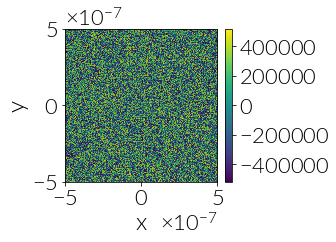

In [5]:
f, ax = plt.subplots(ncols=1, figsize=(3, 3))
system.m.plot_plane('z', ax=ax)

In [6]:
md = oc.MinDriver()

md.drive(system)

2018/09/03 10:17: Running OOMMF (oommf_typeII_bubble/oommf_typeII_bubble.mif) ... (5150.3 s)


# PLOTS

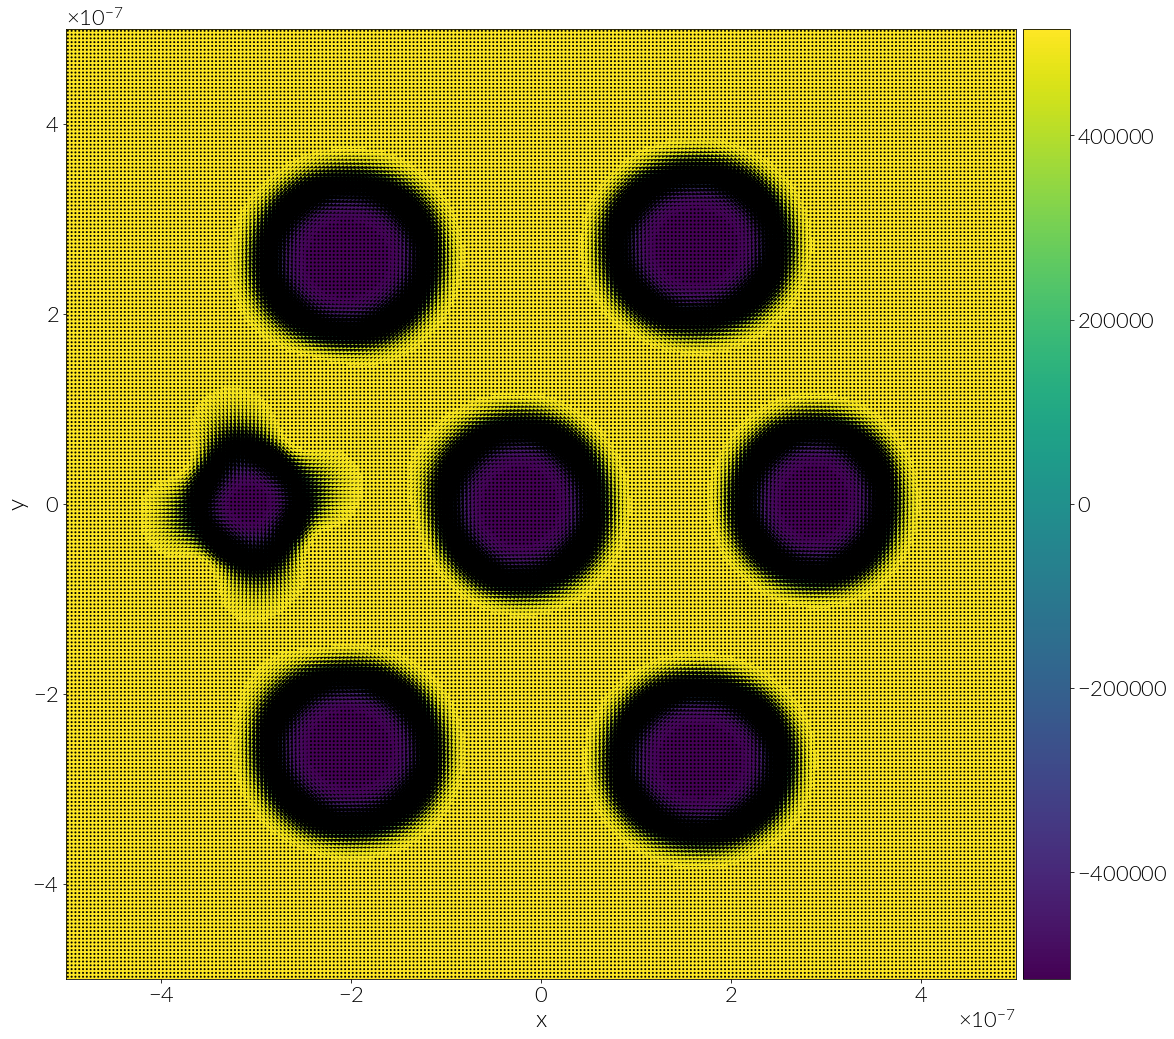

In [10]:
f, ax = plt.subplots(ncols=1, figsize=(18, 18))
system.m.plot_plane('z', ax=ax)

In [14]:
# A list of tuples with the coordinates in the order of systems[2]
coordinates = list(system.m.mesh.coordinates)

# Turn coordinates into a (N, 3) array and save in corresponding variables
# scaled in nm
coordinates = np.array(coordinates)
x_oommf, y_oommf, z_oommf = coordinates[:, 0] * 1e9, coordinates[:, 1] * 1e9, coordinates[:, 2] * 1e9
xs, ys, zs = np.unique(x_oommf), np.unique(y_oommf), np.unique(z_oommf)
# phi_oommf = np.arctan2(y_oommf, x_oommf)
 
# Get the magnetisation for every coordinate in the magnetisation list
values = []
for c in coordinates:
    values.append(system.m(c))
values = np.array(values)

# Save them in the corresponding row and column of the m list
# mx, my, mz:
mx, my, mz = (values[:, 0] / Ms, values[:, 1] / Ms,values[:, 2] / Ms)

# mphi = lambda z_i: (-mx_O * np.sin(phi_O) + my_O * np.cos(phi_O))[_filter_y_O(z_i)]
# mr = lambda z_i: (mx_O * np.cos(phi_O) + my_O * np.sin(phi_O))[_filter_y_O(z_i)]

In [76]:
# system.m.write('m_OOMMF.vtk')

In [16]:
z_filter = z_oommf == zs[10]
rgb_map = generate_RGBs(np.column_stack((mx, my, mz)))

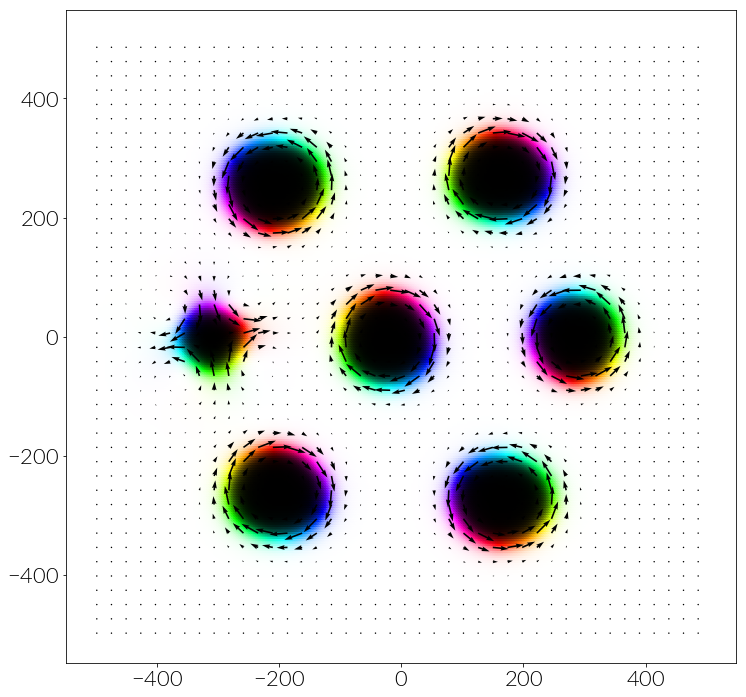

In [25]:
f, ax = plt.subplots(ncols=1, figsize=(12, 12))

plt.scatter(x_oommf[z_filter], y_oommf[z_filter], c=rgb_map[z_filter])
# plt.scatter(x_oommf, y_oommf, c=rgb_map)

# Arrows filter
arr_fltr_tmp = np.zeros(len(xs))
arr_fltr_tmp[::6] = 1
arr_fltr = np.zeros_like(x_oommf[z_filter]).reshape(len(xs), -1)
arr_fltr[::6] = arr_fltr_tmp
arr_fltr = arr_fltr.astype(np.bool).reshape(-1,)

plt.quiver(x_oommf[z_filter][arr_fltr], y_oommf[z_filter][arr_fltr], 
           mx[z_filter][arr_fltr], my[z_filter][arr_fltr],
           scale=35)

plt.savefig('oommf_bubble_random42_Bz200mT.jpg', dpi=300, bbox_inches='tight')

# Load from file

Here we load simulations performed with OOMMF, using different random initial states (different seeds)

In [26]:
import re

In [27]:
class OOMMFDataRead(object):
    
    def __init__(self, input_file):
        
        self.input_file = input_file
        self.read_header()

    def read_header(self):
        
        _file = open(self.input_file)

        # Generate a single string with the whole header up to the line where
        # numerical Data starts
        line = _file.readline()
        data = ''
        while not line.startswith('# Begin: Data Text'):
            data += line
            line = _file.readline()

        attrs = {'xstepsize': 'dx',  'ystepsize': 'dy', 'zstepsize': 'dz',
                 'xbase': 'xbase',  'ybase': 'ybase', 'zbase': 'zbase',
                 'xmin': 'xmin', 'ymin': 'ymin', 'zmin': 'zmin',
                 'xmax': 'xmax', 'ymax': 'ymax', 'zmax': 'zmax',
                 }

        # Regex search the attributes. Stepsizes are specified as dx, dy, dz
        for k in attrs.keys():
            num_val = float(re.search('(?<={}: )[0-9\-\.e]+'.format(k),
                            data).group(0))
            setattr(self, attrs[k], num_val)

        # Compute number of elements in each direction
        self.nx = int((self.xmax - self.xmin) / self.dx)
        self.ny = int((self.ymax - self.ymin) / self.dy)
        self.nz = int((self.zmax - self.zmin) / self.dz)

        _file.close()
        
    def read_m(self):
        data = np.loadtxt(self.input_file)
        Ms = np.sqrt(np.sum(data ** 2, axis=1))
        Ms[Ms == 0.0] = 0.0
        self.mx, self.my, self.mz = (data[:, 0] / Ms,
                                     data[:, 1] / Ms,
                                     data[:, 2] / Ms)
        
    def set_coordinates(self):
        xs, ys, zs = np.arange(float(self.nx)), np.arange(float(self.ny)), np.arange(float(self.nz))
        xs *= self.dx
        xs += self.xbase
        ys *= self.dy
        ys += self.ybase
        zs *= self.dz
        zs += self.zbase
        
        xs = np.tile(np.tile(xs, self.ny), self.nz)
        ys = np.tile(np.repeat(ys, self.nx), self.nz)
        zs = np.repeat(zs, self.nx * self.ny)
        
        # int(len(xs), len(ys), len(zs))
        
        # self.coordinates = np.ravel(np.column_stack((xs, ys, zs))) * 1e9
        self.coordinates = np.column_stack((xs, ys, zs)) * 1e9
        self.x, self.y, self.z = (self.coordinates[:, 0],
                                  self.coordinates[:, 1],
                                  self.coordinates[:, 2])

 # Field Sweep: $A = 20\:\text{pJ m}^{-1}$ 

## Seed: 42

In [8]:
# _file = base_folder + 'oommf_film_random_rseed42_field-sweep-Oxs_MinDriver-Magnetization-01-0000000.omf'
base_folder = '../sims/oommf/film_random_A20pJm-2_mu0Ms648e-3_field-sweep/film_random_rseed42_field-sweep_omfs/'
_file_list = sorted(glob.glob(base_folder + '*Oxs*'), key=lambda f: int(re.search('(?<=Magnetization-)\d+(?=-)', f).group(0)))

m = {}

for F in _file_list:
    hstep = int(re.search('(?<=Magnetization-)\d+(?=-)', F).group(0))
    
    data = OOMMFDataRead(F)
    data.read_m()
    
    m[hstep] = {}
    m[hstep]['mx'] = data.mx
    m[hstep]['my'] = data.my
    m[hstep]['mz'] = data.mz
    m[hstep]['rgbs'] = generate_RGBs(np.column_stack((data.mx, data.my, data.mz)))
    
data = OOMMFDataRead(_file_list[0])
data.set_coordinates()
coordinates = {}
coordinates['x'] = data.x
coordinates['y'] = data.y
coordinates['z'] = data.z

xs, ys, zs = np.unique(coordinates['x']), np.unique(coordinates['y']), np.unique(coordinates['z'])

In [9]:
m.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

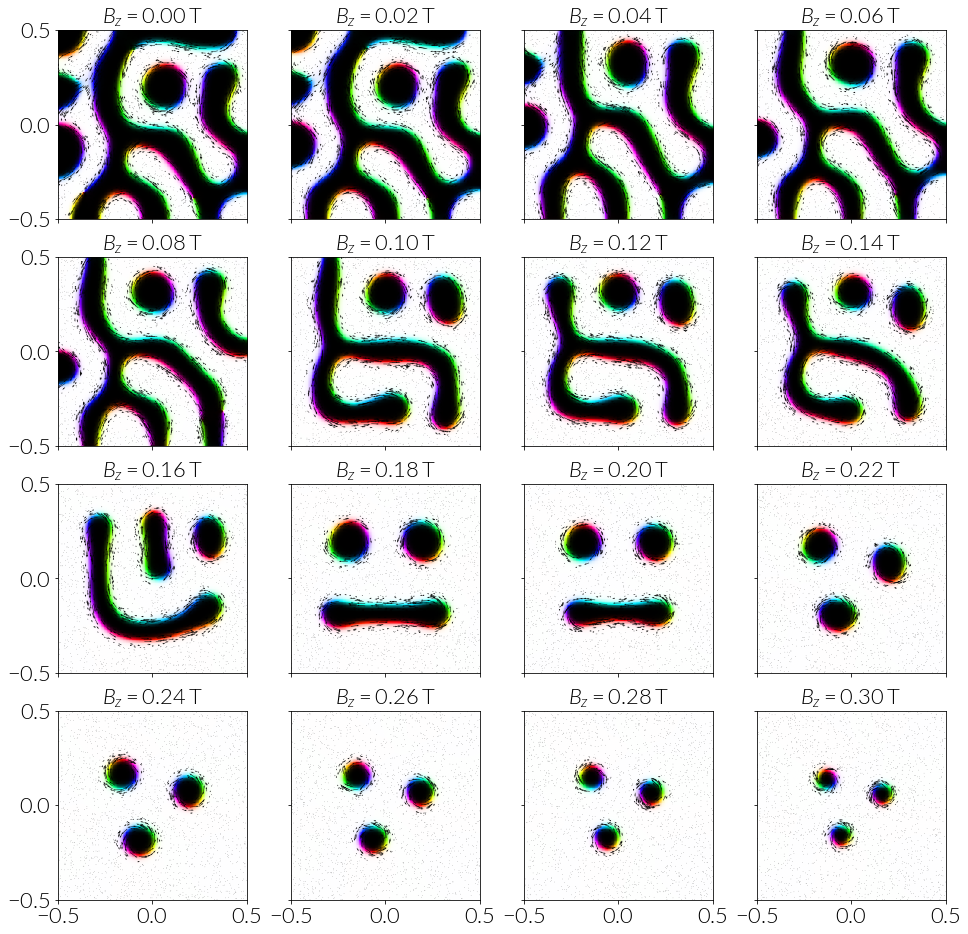

In [10]:
f, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 16), sharex=True, sharey=True)
axl = axs.flatten()

z_filter = coordinates['z'] == np.unique(coordinates['z'])[12]
for i, HS in enumerate(sorted(m.keys())[:]):
    
    dx = xs[1] - xs[0]
    axl[i].imshow(m[HS]['rgbs'][z_filter].reshape(len(xs), -1, 3), 
                  extent=[(xs.min() - dx * 0.5) / 1000, (xs.max() + dx * 0.5) / 1000,
                          (ys.min() - dx * 0.5) / 1000, (ys.max() + dx * 0.5) / 1000,
                          ],
                  origin='lower'
                  )
    axl[i].set_title(r'$B_z = ' + '{:.2f}'.format(0.0 + HS * 0.02) + r'\:\mathrm{T}$')
    # st = 8

    # Random filter fot the arrows:
    np.random.seed = 42
    arr_fltr = np.random.randint(0, high=60, size=len(coordinates['x'][z_filter]))
    arr_fltr[arr_fltr < 58] = 0
    arr_fltr = arr_fltr.astype(np.bool)

    axl[i].quiver(coordinates['x'][z_filter][arr_fltr] / 1000, 
                  coordinates['y'][z_filter][arr_fltr] / 1000, 
                  m[HS]['mx'][z_filter][arr_fltr], m[HS]['my'][z_filter][arr_fltr],
                  scale=8, scale_units='inches')

plt.savefig('bubbles_random_field-sweep_random-seed-42.jpg', bbox_inches='tight', dpi=400)

## Seed: 24

In [25]:
base_folder = '../sims/oommf/film_random_A20pJm-2_mu0Ms648e-3_field-sweep/film_random_rseed24_field-sweep_omfs/'
_file_list = sorted(glob.glob(base_folder + '*Oxs*'), key=lambda f: int(re.search('(?<=Magnetization-)\d+(?=-)', f).group(0)))

m = {}

for F in _file_list:
    hstep = int(re.search('(?<=Magnetization-)\d+(?=-)', F).group(0))
    
    data = OOMMFDataRead(F)
    data.read_m()
    
    m[hstep] = {}
    m[hstep]['mx'] = data.mx
    m[hstep]['my'] = data.my
    m[hstep]['mz'] = data.mz
    m[hstep]['rgbs'] = generate_RGBs(np.column_stack((data.mx, data.my, data.mz)))
    
data = OOMMFDataRead(_file_list[0])
data.set_coordinates()
coordinates = {}
coordinates['x'] = data.x
coordinates['y'] = data.y
coordinates['z'] = data.z

xs, ys, zs = np.unique(coordinates['x']), np.unique(coordinates['y']), np.unique(coordinates['z'])

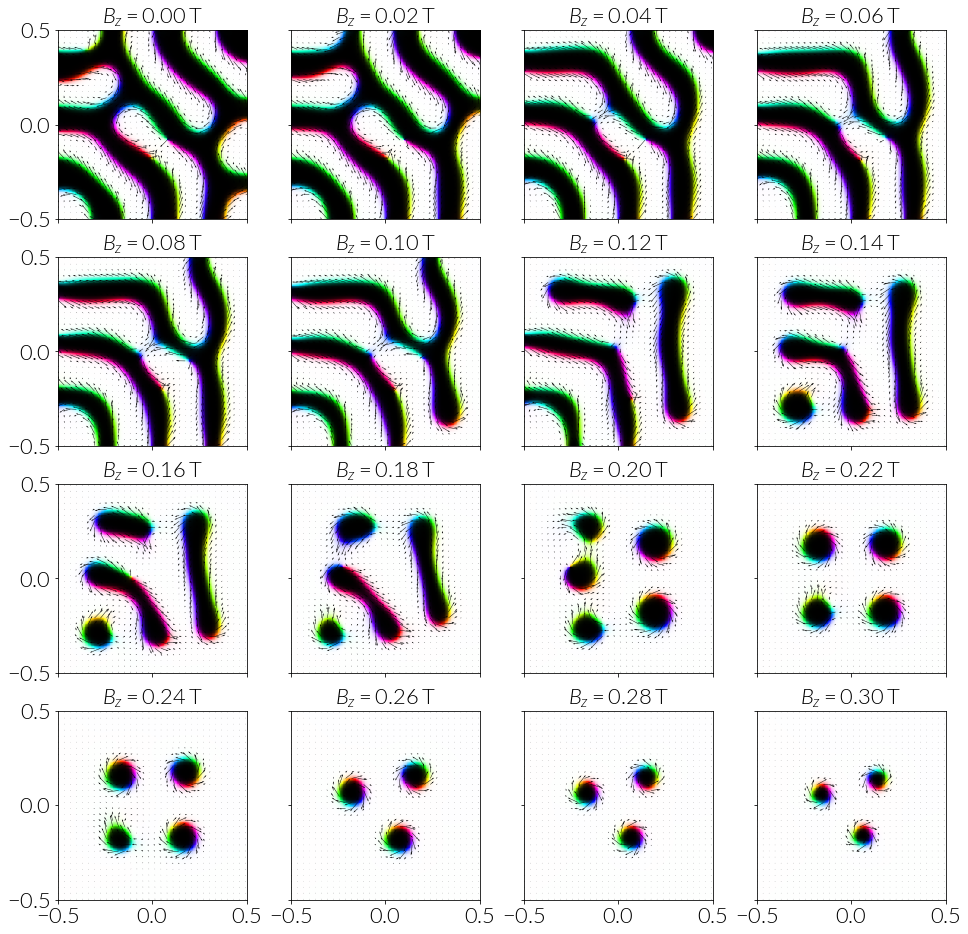

In [26]:
f, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 16), sharex=True, sharey=True)
axl = axs.flatten()

z_filter = coordinates['z'] == np.unique(coordinates['z'])[10]
for i, HS in enumerate(sorted(m.keys())[:]):
    
    dx = xs[1] - xs[0]
    axl[i].imshow(m[HS]['rgbs'][z_filter].reshape(len(xs), -1, 3), 
                  extent=[(xs.min() - dx * 0.5) / 1000, (xs.max() + dx * 0.5) / 1000,
                          (ys.min() - dx * 0.5) / 1000, (ys.max() + dx * 0.5) / 1000,
                          ],
                  origin='lower'
                  )
    axl[i].set_title(r'$B_z = ' + '{:.2f}'.format(0.0 + HS * 0.02) + r'\:\mathrm{T}$')
    # st = 8

    # Filter for the arrows:
    arr_fltr_tmp = np.zeros(len(xs))
    arr_fltr_tmp[::8] = 1
    arr_fltr = np.zeros_like(coordinates['x'][z_filter]).reshape(len(xs), -1)
    arr_fltr[::8] = arr_fltr_tmp
    arr_fltr = arr_fltr.astype(np.bool).reshape(-1,)

    axl[i].quiver(coordinates['x'][z_filter][arr_fltr] / 1000, 
                  coordinates['y'][z_filter][arr_fltr] / 1000, 
                  m[HS]['mx'][z_filter][arr_fltr], m[HS]['my'][z_filter][arr_fltr],
                  scale=6, scale_units='inches')

plt.savefig('bubbles_random_field-sweep_random-seed-24.jpg', bbox_inches='tight', dpi=400)

## Seed: 2424

In [13]:
base_folder = '../sims/oommf/film_random_A20pJm-2_mu0Ms648e-3_field-sweep/film_random_rseed2424_field-sweep_omfs/'
_file_list = sorted(glob.glob(base_folder + '*Oxs*'), key=lambda f: int(re.search('(?<=Magnetization-)\d+(?=-)', f).group(0)))

m = {}

for F in _file_list:
    hstep = int(re.search('(?<=Magnetization-)\d+(?=-)', F).group(0))
    
    data = OOMMFDataRead(F)
    data.read_m()
    
    m[hstep] = {}
    m[hstep]['mx'] = data.mx
    m[hstep]['my'] = data.my
    m[hstep]['mz'] = data.mz
    m[hstep]['rgbs'] = generate_RGBs(np.column_stack((data.mx, data.my, data.mz)))
    
data = OOMMFDataRead(_file_list[0])
data.set_coordinates()
coordinates = {}
coordinates['x'] = data.x
coordinates['y'] = data.y
coordinates['z'] = data.z

xs, ys, zs = np.unique(coordinates['x']), np.unique(coordinates['y']), np.unique(coordinates['z'])

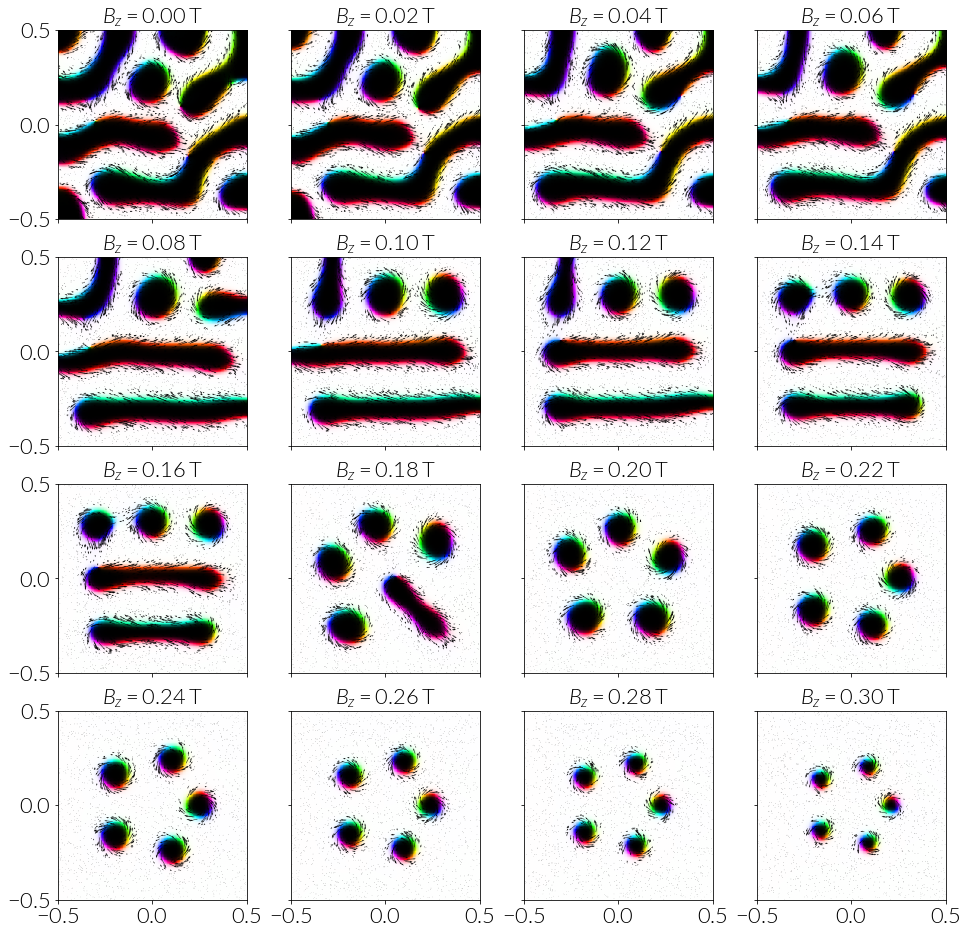

In [14]:
f, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 16), sharex=True, sharey=True)
axl = axs.flatten()

z_filter = coordinates['z'] == np.unique(coordinates['z'])[10]
for i, HS in enumerate(sorted(m.keys())[:]):
    
    dx = xs[1] - xs[0]
    axl[i].imshow(m[HS]['rgbs'][z_filter].reshape(len(xs), -1, 3), 
                  extent=[(xs.min() - dx * 0.5) / 1000, (xs.max() + dx * 0.5) / 1000,
                          (ys.min() - dx * 0.5) / 1000, (ys.max() + dx * 0.5) / 1000,
                          ],
                  origin='lower'
                  )
    axl[i].set_title(r'$B_z = ' + '{:.2f}'.format(0.0 + HS * 0.02) + r'\:\mathrm{T}$')
    # st = 8

    # Random filter fot the arrows:
    np.random.seed = 42
    arr_fltr = np.random.randint(0, high=60, size=len(coordinates['x'][z_filter]))
    arr_fltr[arr_fltr < 58] = 0
    arr_fltr = arr_fltr.astype(np.bool)

    axl[i].quiver(coordinates['x'][z_filter][arr_fltr] / 1000, 
                  coordinates['y'][z_filter][arr_fltr] / 1000, 
                  m[HS]['mx'][z_filter][arr_fltr], m[HS]['my'][z_filter][arr_fltr],
                  scale=8, scale_units='inches')


plt.savefig('bubbles_random_field-sweep_random-seed-2424.jpg', bbox_inches='tight', dpi=400)

## Seed: 4242

In [15]:
base_folder = '../sims/oommf/film_random_A20pJm-2_mu0Ms648e-3_field-sweep/film_random_rseed4242_field-sweep_omfs/'
_file_list = sorted(glob.glob(base_folder + '*Oxs*'), key=lambda f: int(re.search('(?<=Magnetization-)\d+(?=-)', f).group(0)))

m = {}

for F in _file_list:
    hstep = int(re.search('(?<=Magnetization-)\d+(?=-)', F).group(0))
    
    data = OOMMFDataRead(F)
    data.read_m()
    
    m[hstep] = {}
    m[hstep]['mx'] = data.mx
    m[hstep]['my'] = data.my
    m[hstep]['mz'] = data.mz
    m[hstep]['rgbs'] = generate_RGBs(np.column_stack((data.mx, data.my, data.mz)))
    
data = OOMMFDataRead(_file_list[0])
data.set_coordinates()
coordinates = {}
coordinates['x'] = data.x
coordinates['y'] = data.y
coordinates['z'] = data.z

xs, ys, zs = np.unique(coordinates['x']), np.unique(coordinates['y']), np.unique(coordinates['z'])

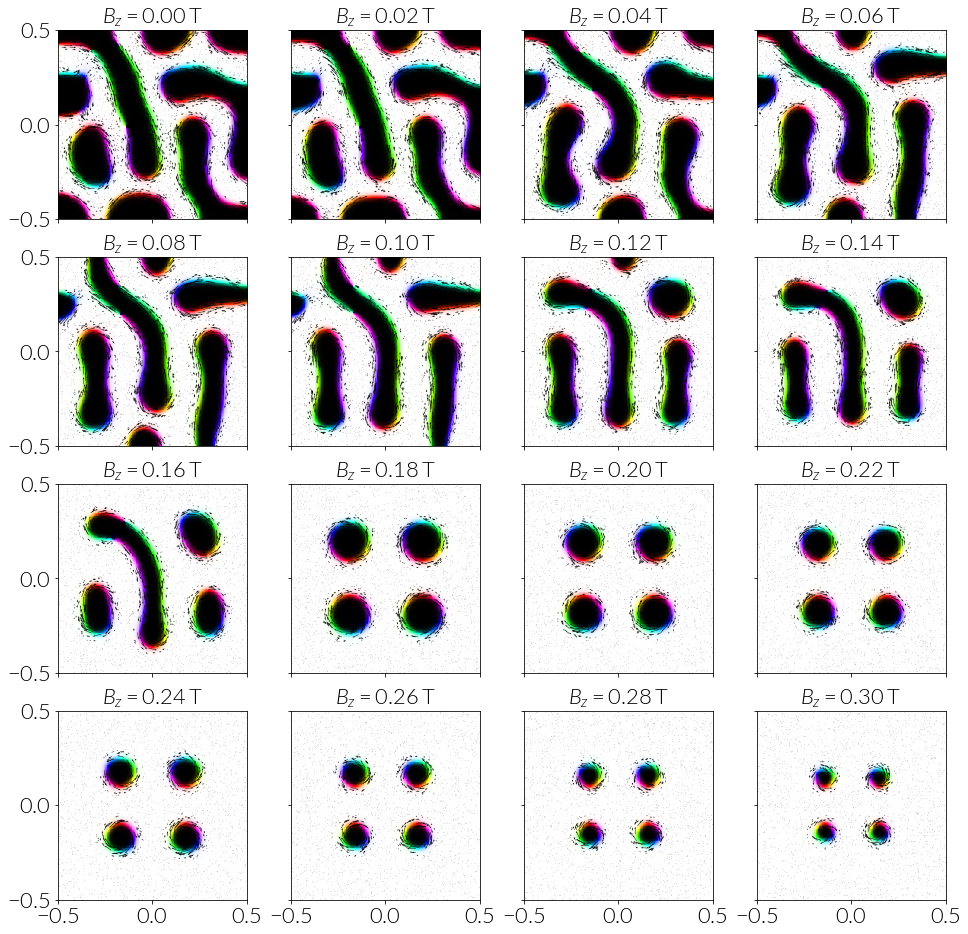

In [16]:
f, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 16), sharex=True, sharey=True)
axl = axs.flatten()

z_filter = coordinates['z'] == np.unique(coordinates['z'])[12]
for i, HS in enumerate(sorted(m.keys())[:]):
    
    dx = xs[1] - xs[0]
    axl[i].imshow(m[HS]['rgbs'][z_filter].reshape(len(xs), -1, 3), 
                  extent=[(xs.min() - dx * 0.5) / 1000, (xs.max() + dx * 0.5) / 1000,
                          (ys.min() - dx * 0.5) / 1000, (ys.max() + dx * 0.5) / 1000,
                          ],
                  origin='lower'
                  )
    axl[i].set_title(r'$B_z = ' + '{:.2f}'.format(0.0 + HS * 0.02) + r'\:\mathrm{T}$')
    # st = 8

    # Random filter fot the arrows:
    np.random.seed = 42
    arr_fltr = np.random.randint(0, high=60, size=len(coordinates['x'][z_filter]))
    arr_fltr[arr_fltr < 58] = 0
    arr_fltr = arr_fltr.astype(np.bool)

    axl[i].quiver(coordinates['x'][z_filter][arr_fltr] / 1000, 
                  coordinates['y'][z_filter][arr_fltr] / 1000, 
                  m[HS]['mx'][z_filter][arr_fltr], m[HS]['my'][z_filter][arr_fltr],
                  scale=8, scale_units='inches')


plt.savefig('bubbles_random_field-sweep_random-seed-4242.jpg', bbox_inches='tight', dpi=400)

## Seed: 424242

In [28]:
base_folder = '../sims/oommf/film_random_A20pJm-2_mu0Ms648e-3_field-sweep/film_random_rseed424242_field-sweep_omfs/'
_file_list = sorted(glob.glob(base_folder + '*Oxs*'), key=lambda f: int(re.search('(?<=Magnetization-)\d+(?=-)', f).group(0)))

m = {}

for F in _file_list:
    hstep = int(re.search('(?<=Magnetization-)\d+(?=-)', F).group(0))
    
    data = OOMMFDataRead(F)
    data.read_m()
    
    m[hstep] = {}
    m[hstep]['mx'] = data.mx
    m[hstep]['my'] = data.my
    m[hstep]['mz'] = data.mz
    m[hstep]['rgbs'] = generate_RGBs(np.column_stack((data.mx, data.my, data.mz)))
    
data = OOMMFDataRead(_file_list[0])
data.set_coordinates()
coordinates = {}
coordinates['x'] = data.x
coordinates['y'] = data.y
coordinates['z'] = data.z

xs, ys, zs = np.unique(coordinates['x']), np.unique(coordinates['y']), np.unique(coordinates['z'])

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


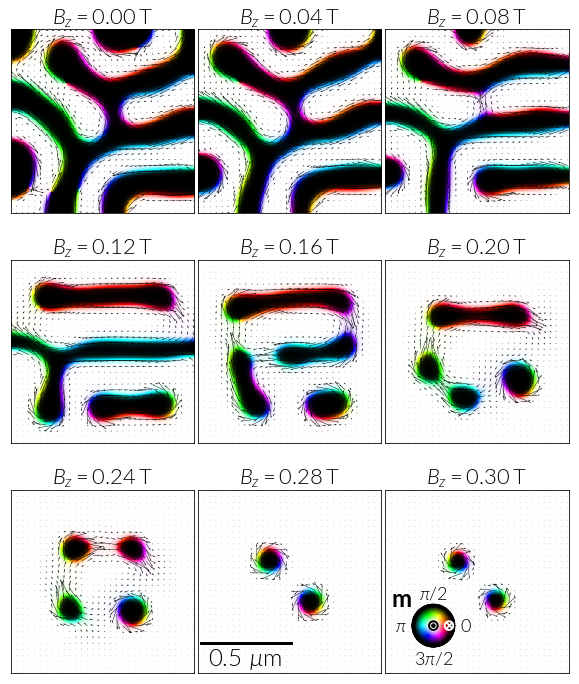

In [119]:
f, axs = plt.subplots(ncols=3, nrows=3, figsize=(10, 12), 
                      sharex=True, sharey=True)
axl = axs.flatten()

z_filter = coordinates['z'] == np.unique(coordinates['z'])[12]
keys = list(sorted(m.keys()))
for i, HS in enumerate(keys[::2] + [keys[-1]]):
    
    dx = xs[1] - xs[0]
    axl[i].imshow(m[HS]['rgbs'][z_filter].reshape(len(xs), -1, 3), 
                  extent=[(xs.min() - dx * 0.5) / 1000, (xs.max() + dx * 0.5) / 1000,
                          (ys.min() - dx * 0.5) / 1000, (ys.max() + dx * 0.5) / 1000,
                          ],
                  origin='lower'
                  )
    axl[i].set_title(r'$B_z = ' + '{:.2f}'.format(0.0 + HS * 0.02) + r'\:\mathrm{T}$')
    # st = 8

    # Filter for the arrows:
    arr_fltr_tmp = np.zeros(len(xs))
    arr_fltr_tmp[::8] = 1
    arr_fltr = np.zeros_like(coordinates['x'][z_filter]).reshape(len(xs), -1)
    arr_fltr[::8] = arr_fltr_tmp
    arr_fltr = arr_fltr.astype(np.bool).reshape(-1,)

    axl[i].quiver(coordinates['x'][z_filter][arr_fltr] / 1000, 
                  coordinates['y'][z_filter][arr_fltr] / 1000, 
                  m[HS]['mx'][z_filter][arr_fltr], m[HS]['my'][z_filter][arr_fltr],
                  scale=4, scale_units='inches')
    
    axl[i].set_xticks([])
    axl[i].set_yticks([])
    
    if i == 7:    
        # Scale Bar
        scalebar = AnchoredSizeBar(axl[i].transData,
                           size=0.5, 
                           label=r'$0.5 \:\: \mu\mathrm{m}$ ', 
                           loc='lower left', 
                           pad=0.,
                           # color='white',
                           frameon=False,
                           size_vertical=0.01,
                           # fontproperties=fontprops
                           )

        axl[i].add_artist(scalebar)
        
    if i == 8:
        
        box = axl[i].get_position()
        axColor = plt.axes([box.x0 + 0.01, box.y0 + 0.03,
                            0.06, 0.06], projection='polar')
        azimuths = np.arange(0, 361, 1)
        # For the y axis, we need an extra element so rgb has 1 less
        # element along the y direction (might change in the future)
        zeniths = np.arange(12, 50, 1)
        dz = 38
        
        # colours have 1 less element along y
        rgb = np.ones((dz * 360, 3))
        # Set the HLS hue value from 0 to 2 PI from the azimuth values
        # We tile the circle 30 times: 
        #   [0 ... 2PI] -> [0...2PI 0 .. 2PI ...]
        rgb[:, 0] = np.tile(azimuths[:-1] * np.pi / 180, dz)
        # For every circle (361 values) we increase the Light value 
        # from 0 to 1, i.e. from black to white, 30 times:
        #  [0 .. 1] -> [0 0 ... 0 1 1 ... 1]
        greys = np.zeros(360)
        greys[:320] = np.linspace(1, 0, 320)
        greys[320:] = 0
        rgb[:, 1] = np.repeat(greys, dz)
        # Now we convert every row in HLS to RGB values
        rgb = np.apply_along_axis(convert_to_RGB, 1, rgb)

        axColor.pcolormesh(azimuths * np.pi / 180.0, zeniths, 
                           # only necessary as required n of args:
                           np.zeros((dz, 360)),
                           # cmap=plt.cm.hsv
                           color=rgb
                           )
        axColor.set_yticks([])
        # axColor.set_xticks([0, np.pi * 0.5, np.pi, 1.5 * np.pi])
        axColor.set_thetagrids([0, 90, 180, 270])
        axColor.tick_params(axis='x', pad=0)
        axColor.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'],
                                fontsize=18
                                )
        
        axColor.text(-0.25, 1.1, r'$\mathbf{m}$', 
                     horizontalalignment='center',
                     verticalalignment='center', transform=axColor.transAxes, 
                     # fontsize=18,
                     # fontweight='bold'
                     )

        axColor.set_rlim(0, 50)
        circle = plt.Circle((0., 0.), 10, transform=axColor.transData._b,
                   edgecolor='k', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        circle = plt.Circle((0., 0.), 3, transform=axColor.transData._b, 
                           color='k', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        circle = plt.Circle((36., 0.), 10, transform=axColor.transData._b,
                   edgecolor='w', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        mymarker = plt.scatter(35., 1., s=40, c='w', 
                               transform=axColor.transData._b,
                               marker='x', clip_on=False)
        axColor.add_artist(mymarker)
    
plt.subplots_adjust(wspace=0.02)

plt.savefig('bubbles_random_field-sweep_random-seed-424242.jpg', bbox_inches='tight', dpi=120)

A smaller plot:

In [19]:
m.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [20]:
m[0]['rgbs']

array([[1.        , 0.98709063, 0.96776621],
       [1.        , 0.9885599 , 0.96918739],
       [1.        , 0.99049898, 0.9712512 ],
       ...,
       [0.03170096, 0.        , 0.03107971],
       [0.02272888, 0.        , 0.02611784],
       [0.01759939, 0.        , 0.02317713]])

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


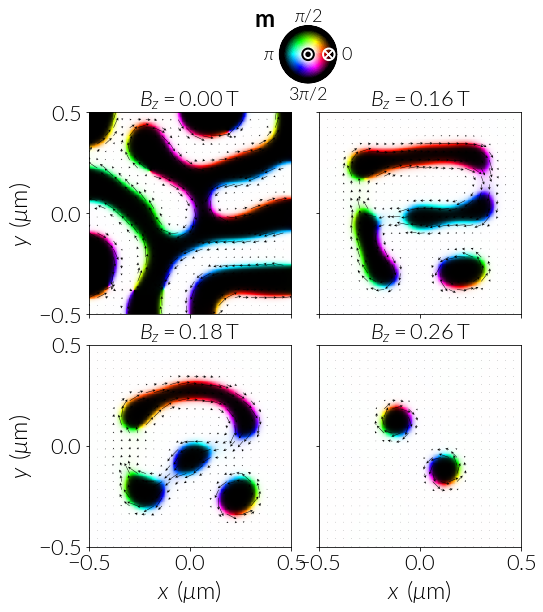

In [21]:
f, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), sharex=True, sharey=True)
axl = axs.flatten()

z_filter = coordinates['z'] == np.unique(coordinates['z'])[12]
for i, HS in enumerate([0, 8, 9, 13]):
    
    dx = xs[1] - xs[0]
    axl[i].imshow(m[HS]['rgbs'][z_filter].reshape(len(xs), -1, 3), 
                  extent=[(xs.min() - dx * 0.5) / 1000, (xs.max() + dx * 0.5) / 1000,
                          (ys.min() - dx * 0.5) / 1000, (ys.max() + dx * 0.5) / 1000,
                          ],
                  origin='lower'
                  # s=5, marker='s'
                  )
    
#     axl[i].scatter(coordinates['x'][z_filter] / 1000, 
#                    coordinates['y'][z_filter] / 1000, 
#                    c=m[HS]['rgbs'][z_filter], 
#                    s=5, marker='s')
    axl[i].set_title(r'$B_z = ' + '{:.2f}'.format(0.0 + HS * 0.02) + r'\:\mathrm{T}$')
    # st = 8

    # Filter for the arrows:
    arr_fltr_tmp = np.zeros(len(xs))
    arr_fltr_tmp[::10] = 1
    arr_fltr = np.zeros_like(coordinates['x'][z_filter]).reshape(len(xs), -1)
    arr_fltr[::10] = arr_fltr_tmp
    arr_fltr = arr_fltr.astype(np.bool).reshape(-1,)

    axl[i].quiver(coordinates['x'][z_filter][arr_fltr] / 1000, 
                  coordinates['y'][z_filter][arr_fltr] / 1000, 
                  m[HS]['mx'][z_filter][arr_fltr],
                  m[HS]['my'][z_filter][arr_fltr],
                  scale=6, scale_units='inches',
                  headlength=6, headwidth=6
                  # scale_units='xy', angles='xy', scale=10
                  )
    
    if i % 2 == 0:
        axl[i].set_ylabel(r'$y \:\: (\mu\mathrm{m}$) ')
    if i > 1:
        axl[i].set_xlabel(r'$x \:\: (\mu\mathrm{m}$) ')
        
    if i == 1:
        
        box = axl[i].get_position()
        axColor = plt.axes([box.x0 - 0.08, box.y1 + 0.05,
                            0.1, 0.1], projection='polar')
        azimuths = np.arange(0, 361, 1)
        # For the y axis, we need an extra element so rgb has 1 less
        # element along the y direction (might change in the future)
        zeniths = np.arange(12, 50, 1)
        dz = 38
        
        # colours have 1 less element along y
        rgb = np.ones((dz * 360, 3))
        # Set the HLS hue value from 0 to 2 PI from the azimuth values
        # We tile the circle 30 times: 
        #   [0 ... 2PI] -> [0...2PI 0 .. 2PI ...]
        rgb[:, 0] = np.tile(azimuths[:-1] * np.pi / 180, dz)
        # For every circle (361 values) we increase the Light value 
        # from 0 to 1, i.e. from black to white, 30 times:
        #  [0 .. 1] -> [0 0 ... 0 1 1 ... 1]
        greys = np.zeros(360)
        greys[:300] = np.linspace(1, 0, 300)
        greys[300:] = 0
        rgb[:, 1] = np.repeat(greys, dz)
        # Now we convert every row in HLS to RGB values
        rgb = np.apply_along_axis(convert_to_RGB, 1, rgb)

        axColor.pcolormesh(azimuths * np.pi / 180.0, zeniths, 
                           # only necessary as required n of args:
                           np.zeros((dz, 360)),
                           # cmap=plt.cm.hsv
                           color=rgb
                           )
        axColor.set_yticks([])
        # axColor.set_xticks([0, np.pi * 0.5, np.pi, 1.5 * np.pi])
        axColor.set_thetagrids([0, 90, 180, 270])
        axColor.tick_params(axis='x', pad=0)
        axColor.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'],
                                fontsize=18
                                )
        
        axColor.text(-0.25, 1.1, r'$\mathbf{m}$', 
                     horizontalalignment='center',
                     verticalalignment='center', transform=axColor.transAxes, 
                     # fontsize=18,
                     # fontweight='bold'
                     )

        axColor.set_rlim(0, 50)
        circle = plt.Circle((0., 0.), 10, transform=axColor.transData._b,
                   edgecolor='k', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        circle = plt.Circle((0., 0.), 3, transform=axColor.transData._b, 
                           color='k', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        circle = plt.Circle((36., 0.), 10, transform=axColor.transData._b,
                   edgecolor='w', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        mymarker = plt.scatter(35., 1., s=60, c='w', 
                               transform=axColor.transData._b,
                               marker='x', clip_on=False)
        axColor.add_artist(mymarker)

        
plt.subplots_adjust(wspace=0.065, hspace=0.15)

plt.savefig('bubbles_random_field-sweep_random-seed-424242_L1000nm_t100nm.pdf', 
            bbox_inches='tight', dpi=400)

In [54]:
import matplotlib_scalebar.scalebar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


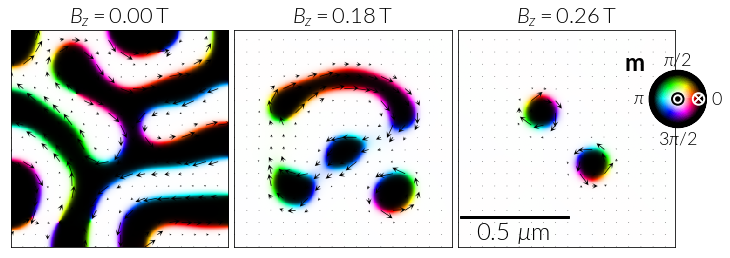

In [92]:
f, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), sharey=True)
axl = axs.flatten()

z_filter = coordinates['z'] == np.unique(coordinates['z'])[12]
for i, HS in enumerate([0, 9, 13]):
    
    dx = xs[1] - xs[0]
    axl[i].imshow(m[HS]['rgbs'][z_filter].reshape(len(xs), -1, 3), 
                  extent=[(xs.min() - dx * 0.5) / 1000, (xs.max() + dx * 0.5) / 1000,
                          (ys.min() - dx * 0.5) / 1000, (ys.max() + dx * 0.5) / 1000,
                          ],
                  origin='lower'
                  # s=5, marker='s'
                  )
    
#     axl[i].scatter(coordinates['x'][z_filter] / 1000, 
#                    coordinates['y'][z_filter] / 1000, 
#                    c=m[HS]['rgbs'][z_filter], 
#                    s=5, marker='s')
    axl[i].set_title(r'$B_z = ' + '{:.2f}'.format(0.0 + HS * 0.02) + r'\:\mathrm{T}$')
    # st = 8

    # Filter for the arrows:
    arr_fltr_tmp = np.zeros(len(xs))
    arr_fltr_tmp[::14] = 1
    arr_fltr = np.zeros_like(coordinates['x'][z_filter]).reshape(len(xs), -1)
    arr_fltr[::14] = arr_fltr_tmp
    arr_fltr = arr_fltr.astype(np.bool).reshape(-1,)

    axl[i].quiver(coordinates['x'][z_filter][arr_fltr] / 1000, 
                  coordinates['y'][z_filter][arr_fltr] / 1000, 
                  m[HS]['mx'][z_filter][arr_fltr],
                  m[HS]['my'][z_filter][arr_fltr],
                  scale=5, scale_units='inches',
                  headlength=8, headwidth=8
                  # scale_units='xy', angles='xy', scale=10
                  )
    
    axl[i].set_xticks([])
    axl[i].set_yticks([])
    
#     if i == 0:
#         axl[i].set_ylabel(r'$y \:\: (\mu\mathrm{m}$) ')
#     if i > -1:
#         axl[i].set_xlabel(r'$x \:\: (\mu\mathrm{m}$) ')
        
    if i == 2:
        
        box = axl[i].get_position()
        axColor = plt.axes([0.8, 0.54,
                            0.2, 0.2], projection='polar')
        azimuths = np.arange(0, 361, 1)
        # For the y axis, we need an extra element so rgb has 1 less
        # element along the y direction (might change in the future)
        zeniths = np.arange(12, 50, 1)
        dz = 38
        
        # colours have 1 less element along y
        rgb = np.ones((dz * 360, 3))
        # Set the HLS hue value from 0 to 2 PI from the azimuth values
        # We tile the circle 30 times: 
        #   [0 ... 2PI] -> [0...2PI 0 .. 2PI ...]
        rgb[:, 0] = np.tile(azimuths[:-1] * np.pi / 180, dz)
        # For every circle (361 values) we increase the Light value 
        # from 0 to 1, i.e. from black to white, 30 times:
        #  [0 .. 1] -> [0 0 ... 0 1 1 ... 1]
        greys = np.zeros(360)
        greys[:300] = np.linspace(1, 0, 300)
        greys[300:] = 0
        rgb[:, 1] = np.repeat(greys, dz)
        # Now we convert every row in HLS to RGB values
        rgb = np.apply_along_axis(convert_to_RGB, 1, rgb)

        axColor.pcolormesh(azimuths * np.pi / 180.0, zeniths, 
                           # only necessary as required n of args:
                           np.zeros((dz, 360)),
                           # cmap=plt.cm.hsv
                           color=rgb
                           )
        axColor.set_yticks([])
        # axColor.set_xticks([0, np.pi * 0.5, np.pi, 1.5 * np.pi])
        axColor.set_thetagrids([0, 90, 180, 270])
        axColor.tick_params(axis='x', pad=0)
        axColor.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'],
                                fontsize=18
                                )
        
        axColor.text(-0.25, 1.1, r'$\mathbf{m}$', 
                     horizontalalignment='center',
                     verticalalignment='center', transform=axColor.transAxes, 
                     # fontsize=18,
                     # fontweight='bold'
                     )

        axColor.set_rlim(0, 50)
        circle = plt.Circle((0., 0.), 10, transform=axColor.transData._b,
                   edgecolor='k', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        circle = plt.Circle((0., 0.), 3, transform=axColor.transData._b, 
                           color='k', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        circle = plt.Circle((36., 0.), 10, transform=axColor.transData._b,
                   edgecolor='w', facecolor='None', linewidth=2)
        axColor.add_artist(circle)
        mymarker = plt.scatter(35., 1., s=60, c='w', 
                               transform=axColor.transData._b,
                               marker='x', clip_on=False)
        axColor.add_artist(mymarker)
        
    
    if i == 2:    
        # Scale Bar
        scalebar = AnchoredSizeBar(axl[i].transData,
                           size=0.5, 
                           label=r'$0.5 \:\: \mu\mathrm{m}$ ', 
                           loc='lower left', 
                           pad=0.,
                           # color='white',
                           frameon=False,
                           size_vertical=0.01,
                           # fontproperties=fontprops
                           )

        axl[i].add_artist(scalebar)

        
plt.subplots_adjust(wspace=0.005, hspace=0.15)

plt.savefig('bubbles_random_field-sweep_random-seed-424242_L1000nm_t100nm.jpg', 
            bbox_inches='tight', dpi=150)

## Seed: 424242 (small time steps)

In [7]:
base_folder = '../sims/oommf/film_random_A20pJm-2_mu0Ms648e-3_field-sweep/film_random_rseed424242_field-sweep_omfs_smallDT/'
_file_list = sorted(glob.glob(base_folder + '*Oxs*'), key=lambda f: int(re.search('(?<=Magnetization-)\d+(?=-)', f).group(0)))

m = {}

for F in _file_list[:]:
    hstep = int(re.search('(?<=Magnetization-)\d+(?=-)', F).group(0))
    print('Computing {}'.format(hstep))
    
    data = OOMMFDataRead(F)
    data.read_m()
    
    m[hstep] = {}
    m[hstep]['mx'] = data.mx
    m[hstep]['my'] = data.my
    m[hstep]['mz'] = data.mz
    m[hstep]['rgbs'] = generate_RGBs(np.column_stack((data.mx, data.my, data.mz)))
    
data = OOMMFDataRead(_file_list[0])
data.set_coordinates()
coordinates = {}
coordinates['x'] = data.x
coordinates['y'] = data.y
coordinates['z'] = data.z

xs, ys, zs = np.unique(coordinates['x']), np.unique(coordinates['y']), np.unique(coordinates['z'])

Computing 0
Computing 1
Computing 2
Computing 3
Computing 4
Computing 5
Computing 6
Computing 7
Computing 8
Computing 9
Computing 10
Computing 11
Computing 12
Computing 13
Computing 14
Computing 15
Computing 16
Computing 17
Computing 18
Computing 19
Computing 20
Computing 21
Computing 22
Computing 23
Computing 24
Computing 25
Computing 26
Computing 27
Computing 28
Computing 29
Computing 30
Computing 31
Computing 32
Computing 33
Computing 34
Computing 35
Computing 36
Computing 37
Computing 38
Computing 39
Computing 40
Computing 41
Computing 42
Computing 43
Computing 44
Computing 45
Computing 46
Computing 47
Computing 48
Computing 49
Computing 50
Computing 51
Computing 52
Computing 53
Computing 54
Computing 55
Computing 56
Computing 57
Computing 58
Computing 59
Computing 60
Computing 61
Computing 62
Computing 63
Computing 64
Computing 65
Computing 66
Computing 67
Computing 68
Computing 69
Computing 70
Computing 71
Computing 72
Computing 73
Computing 74
Computing 75
Computing 76
Computing

## Snapshots for video:

In [ ]:
!mkdir pngs_DT

In [11]:
for HS in range(257):
    f, axs = plt.subplots(ncols=1, nrows=1, figsize=(8, 8), sharey=True)
    ax = axs

    z_filter = coordinates['z'] == np.unique(coordinates['z'])[12]
    # HS = 41

    dx = xs[1] - xs[0]
    ax.imshow(m[HS]['rgbs'][z_filter].reshape(len(xs), -1, 3), 
              extent=[(xs.min() - dx * 0.5) / 1000, (xs.max() + dx * 0.5) / 1000,
                      (ys.min() - dx * 0.5) / 1000, (ys.max() + dx * 0.5) / 1000,
                      ],
              origin='lower'
              )
    ax.set_title(r'$B_z = ' + '{:.3f}'.format(0.0 + HS * 0.001) + r'\:\mathrm{T}$')

    # Filter for the arrows:
    arr_fltr_tmp = np.zeros(len(xs))
    arr_fltr_tmp[::6] = 1
    arr_fltr = np.zeros_like(coordinates['x'][z_filter]).reshape(len(xs), -1)
    arr_fltr[::6] = arr_fltr_tmp
    arr_fltr = arr_fltr.astype(np.bool).reshape(-1,)

    ax.quiver(coordinates['x'][z_filter][arr_fltr] / 1000, 
              coordinates['y'][z_filter][arr_fltr] / 1000, 
              m[HS]['mx'][z_filter][arr_fltr],
              m[HS]['my'][z_filter][arr_fltr],
              scale=6, scale_units='inches',
              # headlength=8, headwidth=8
              # scale_units='xy', angles='xy', scale=10
              )

    ax.set_ylabel(r'$y \:\: (\mu\mathrm{m}$) ')
    ax.set_xlabel(r'$x \:\: (\mu\mathrm{m}$) ')

    plt.savefig('pngs/{:06d}.png'.format(HS), 
                bbox_inches='tight', dpi=80)
    
    plt.close()